*Partiendo de todo **menos consecionarias**, ver en la muestra de MELI que están actualmente activos y agregandolos por marca, modelo y version, hacerles un size() para luego separarlos en percentiles en base al size y de esta forma para comenzar a plantear los 3 escenarios de scoreo:*
   * A) Cotizamos mediante el algortimo (alta presencia en meli + criterio de negocio)
       * Este escenario despues se puede aperturar en 2 o más modelos cuya diferencia entre sí sea la base de entrenamiento y por lo tanto el objetivo de prediccion. La onda sería que cada base de train haga foco en cierto tipo de muestra, como por ejemplo a) autos < 100_000 kms // b) autos > 100_000 kms // etc. Todo esto con el objetivo de hacer modelos más customizados
   * B) Cotizamos mediante reglas hardcodeadas (mediana presencia + criterio de negocio)
   * C) NO cotizamos y le pasamos el lead el equipo de pricing analysts (baja presencia + criterio de negocio) 

- Para la ppt mostrar nuestras exclusiones para el entrenamiento del modelo.
- Mirar las marcas con mas cantidad de outliers y entender si hay correlación con la presencia (size), porque muchas veces que haya outliers quiere lo hacen adrede para llamar la atención porq justamente hay muchisima presencia (en ese caso la correlacion sería positiva). Para definir cuando es un outlier podemos usar la formula del boxplot ;)
- Mirar los desvios standards o coeficiente de variacion con el mismo foco que los outliers
- Cantidad de versiones y volatilidad de los promedios de las versiones, (aparte esto quisas puede ser el procesamiento de la variable version que estabamos pensando). Ya que si el precio no varía, es innecesario que tengan valores distintos en las versiones, en esos casos podríamos estandarizar y usar un placeholder para que les quede el mismo valor a todas.
- Discontinuados, cuales son y que presencia tienen en MELI, capas que si tienen mucha presencia no importa (todavia no lo podemos hacer hasta tener esa variable sana en el datawarehouse) -- preg a Favio como viene ese tema

In [1]:
##### Librerías y modulos #######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
import openpyxl
import random

In [2]:
####### Configuraciones de la notebook (a gusto del usuario) ##########
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [3]:
path_save = '../datos/'

In [3]:
####### requierments ###########
#!pip install pandas-gbq

In [4]:
# Importar tabla OOT de Big Query
#df_scoreo_oot = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.match_meli_ok` WHERE date > '2022-01-01' ", project_id="data-team-k")

In [4]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-03-02.pkl'.format(path_save))

In [6]:
# chequeo
print(len(df))
print(df.date.min(), df.date.max())

2592757
2022-02-02 00:00:00 2022-03-01 00:00:00


In [6]:
# checkpoint download
#df.to_csv('checkp_df_scoreo_oot.csv')

In [4]:
# checkpoint upload
#df_scoreo_oot = pd.read_csv('checkp_df_scoreo_oot.csv')

In [7]:
df_scoreo_oot = df.copy()

# 0) Pre procesing

**Removing duplicates**

In [8]:
# Tratamiento de la feautre "runtime"
df_scoreo_oot['runtime'] = pd.to_datetime(df_scoreo_oot.runtime.apply(lambda x: str(x)[:19]))
df_scoreo_oot = df_scoreo_oot.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df_scoreo_oot.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [9]:
df_scoreo_oot.shape

(141300, 42)

**Removing 0km & concesionaria**

In [10]:
# Pasamos "dealer" de booleano a flag 1 y 0
df_scoreo_oot['dealer'] = np.where(df_scoreo_oot['dealer']==True,1,0)
mask_not_0km = df_scoreo_oot.car_kms > 90
mask_not_conces = df_scoreo_oot.dealer == 0

df_scoreo_oot = df_scoreo_oot[(mask_not_0km) & (mask_not_conces)]

# Como nos quedamos con solamente un valor de la feature "dealer" la podemos eliminar
df_scoreo_oot.drop('dealer',1,inplace=True)

**Removing match_scores under 50%**

In [11]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df_scoreo_oot = df_scoreo_oot[df_scoreo_oot[col]>=50]
    
# chequeo
df_scoreo_oot[lst].min()

score_marca_a    90.0000
score_modelo_a   50.0000
score_v1_c       50.0000
dtype: float64

Pendiente: Hacer el trackeo de que marcas excluímos con esta limpieza por concesionaria y matcheo

**Tratamiento de feature precio**

In [12]:
# Construcción del precio final
blue= 206
oficial= 114.18
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df_scoreo_oot[col1]!='U$S', (df_scoreo_oot[col1]=='U$S') & (df_scoreo_oot[col2]==0), (df_scoreo_oot[col1]=='U$S') & (df_scoreo_oot[col2]!=0)]
choices = [df_scoreo_oot.price_amount, df_scoreo_oot['price_amount']*oficial, df_scoreo_oot['price_amount']*blue]

df_scoreo_oot['price_meli_ok'] = np.select(conditions, choices, default=np.nan)
# Luego de ya tener el precio final calculado, podemos eliminar del dataset las variables de precio originales
df_scoreo_oot.drop(['price_symbol','price_amount'],1,inplace=True)

**Dataframe final**

In [13]:
df_final = df_scoreo_oot[['car_id','runtime','date','price_meli_ok','car_year','car_kms','car_location_1'
               ,'match_marca_a','match_modelo_a','match_v1_a','Seg_a','Subseg_a']]
df_final.columns = ['car_id','runtime','date','price_meli_ok','car_year','car_kms','car_location_1'
               ,'marca_a','modelo_a','version_a','seg_a','subseg_a']
df_final.head()

,car_id,runtime,date,price_meli_ok,car_year,car_kms,car_location_1,marca_a,modelo_a,version_a,seg_a,subseg_a
2312466,1116345598,2022-02-02 00:00:24,2022-02-02,1200000.0000,2012,180007.0000,Buenos Aires Interior,FIAT,Strada,Trekking C/Simple 1.3 JTD AA Seg.,Livianos,Baja PU - Furgones
1562583,1121420244,2022-02-02 00:00:26,2022-02-02,1500000.0000,2012,135000.0000,Entre Ríos,FIAT,Strada,1.6 16v Adventure Extreme (115cv),Livianos,Baja PU - Furgones
1721124,1114994587,2022-02-02 00:00:26,2022-02-02,5253000.0000,2020,32000.0000,Capital Federal,FIAT,Toro,2.0 Volcano 4x4 9AT Cab/Doble Pack Premium,Livianos,Pickups Compactas
1560422,1118085725,2022-02-02 00:00:28,2022-02-02,710000.0000,2013,300000.0000,Capital Federal,RENAULT,Fluence,1.6 Confort Plus MT (110cv),Gama Medianos,Gama Medianos Sedan
264089,1121532342,2022-02-02 00:00:28,2022-02-02,1350000.0000,2013,104000.0000,Bs.As. G.B.A. Oeste,RENAULT,Fluence,1.6 Confort Plus MT (110cv),Gama Medianos,Gama Medianos Sedan


**Preparacion flag de outliers**

*Q3+3*RIC. < outlier*

**Coeficiente de variacion:** <br>
A mayor valor del coeficiente de variación mayor heterogeneidad de los valores de la variable; y a menor C.V., mayor homogeneidad en los valores de la variable

In [14]:
df_final.describe()

,price_meli_ok,car_year,car_kms
count,55218.0000,55218.0000,55218.0000
mean,2740590.1903,2013.8427,107088.6621
std,3715341.0046,3.7216,110616.8474
min,50000.0000,2006.0000,95.0000
25%,1338227.5000,2011.0000,58000.0000
50%,2000000.0000,2014.0000,98000.0000
75%,3200000.0000,2017.0000,142000.0000
max,228888866.0000,2021.0000,11111111.0000


In [28]:
q1 = df_final.price_meli_ok.quantile(0.25)
q3 = df_final.price_meli_ok.quantile(0.75)
IQR = q3 - q1

outl_thresh_superior = q3+4.5*IQR
outl_thresh_superior

11577976.25

In [26]:
q1 = df_final.car_kms.quantile(0.25)
q3 = df_final.car_kms.quantile(0.75)
IQR = q3 - q1

outl_thresh_superior = q3+1.5*IQR
outl_thresh_superior

268000.0

In [19]:
df_final.price_meli_ok.quantile(0.99)

11500000.0

<AxesSubplot:xlabel='price_meli_ok'>

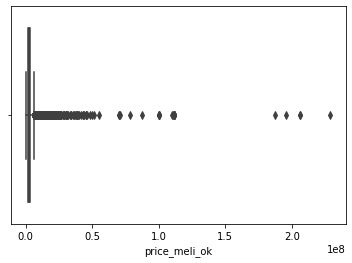

In [20]:
sns.boxplot(df_final.price_meli_ok)

<AxesSubplot:xlabel='price_meli_ok'>

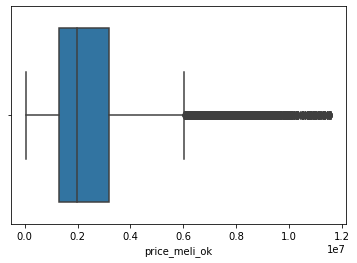

In [33]:
sns.boxplot(df_final[df_final.price_meli_ok<=11577976.25]['price_meli_ok'])

In [37]:
# PRECIO
q1 = df_final.price_meli_ok.quantile(0.25)
q3 = df_final.price_meli_ok.quantile(0.75)
IQR = q3 - q1

outl_thresh_superior = q3+4.5*IQR
#outl_thresh_inferior = q1-3*IQR    -- para el precio no vale la pena hacer esto del outl inferior, en kms si
print(f'Outlier superior threshold: {outl_thresh_superior}')
#print(f'Outlier inferior threshold: {outl_thresh_inferior}')
df_final['flag_outlier_price'] = ((df_final.price_meli_ok > outl_thresh_superior))*1
                                  #| (df_final.price_meli_ok < outl_thresh_inferior))*1
# chequeos
display(df_final[df_final['flag_outlier_price']==1].head())
display(df_final.price_meli_ok.describe(percentiles=[0.05,0.25,0.75,0.85,0.90,0.95,0.98,0.99]))

# KMS
# en este caso es importante que tambien tenga en cuenta el año ejemplo un auto de 2006 con 200km seguro es outlier compitiendo con
## los 2006 pero compitiendo con 2021 no sería outlier, Esto sería clave para preprocesar la base del entrenamiento del modelo
q1 = df_final.car_kms.quantile(0.25)
q3 = df_final.car_kms.quantile(0.75)
IQR = q3 - q1
# me parece que la onda pasa por hacer un groupby por año con una agg(lambda x) hacer el flag de outliers
# luego ese df temp joinearlo con el master
outl_thresh_superior = q3+1.5*IQR
outl_thresh_inferior = q1-1.5*IQR # con esto noo terminamos captando ninguno ya que no tenemos valores negativos
print(f'Outlier threshold superior for kms: {outl_thresh_superior}')
print(f'Outlier threshold inferior for kms: {outl_thresh_inferior}')
mask1 = df_final.car_kms > outl_thresh_superior
mask2 = df_final.car_kms < outl_thresh_inferior
df_final['flag_outlier_kms'] = np.where(mask1 | mask2, 1, 0)
# # chequeos
display('\n')
display(df_final[df_final['flag_outlier_kms']==1].head())
display(df_final.car_kms.describe(percentiles=[0.01, 0.25,0.75,0.85,0.90,0.95,0.98,0.99]))

Outlier superior threshold: 11577976.25


,car_id,runtime,date,price_meli_ok,car_year,car_kms,car_location_1,marca_a,modelo_a,version_a,seg_a,subseg_a,flag_outlier_price,flag_outlier_kms
1461332,1114728748,2022-02-02 02:00:31,2022-02-02,13575400.0000,2019,27000.0000,Santa Fe,VOLVO,XC60,T5 2.0T Momentum AWD (247hp) (L18),SUV,SUV 4X4,1,0
1462933,1114832192,2022-02-02 10:00:33,2022-02-02,17510000.0000,2018,9000.0000,Capital Federal,CHEVROLET,Camaro,SS V8 6.2 8AT Convertible (461cv) (L17),Premium,Premium,1,0
1301051,1118437097,2022-02-02 20:00:27,2022-02-02,16480000.0000,2017,19500.0000,Santa Fe,FORD,Mustang,GT 5.0L 6MT (421cv),Premium,Premium,1,0
421641,1121013183,2022-02-02 21:01:12,2022-02-02,28840000.0000,2011,160000.0000,Bs.As. G.B.A. Norte,BMW,X1,20d sDrive Active MT 4x2 (177cv),SUV,SUV Premium,1,0
6043,1114938405,2022-02-02 22:00:37,2022-02-02,14317000.0000,2018,16000.0000,Tierra del Fuego,MERCEDES BENZ,Clase GLC,300 4Matic (241cv),SUV,SUV 4X4,1,0


count       55218.0000
mean      2740590.1903
std       3715341.0046
min         50000.0000
5%         800000.0000
25%       1338227.5000
50%       2000000.0000
75%       3200000.0000
85%       4200000.0000
90%       5129400.0000
95%       6798000.0000
98%       9270000.0000
99%      11500000.0000
max     228888866.0000
Name: price_meli_ok, dtype: float64

Outlier threshold superior for kms: 268000.0
Outlier threshold inferior for kms: -68000.0


'\n'

,car_id,runtime,date,price_meli_ok,car_year,car_kms,car_location_1,marca_a,modelo_a,version_a,seg_a,subseg_a,flag_outlier_price,flag_outlier_kms
1560422,1118085725,2022-02-02 00:00:28,2022-02-02,710000.0000,2013,300000.0000,Capital Federal,RENAULT,Fluence,1.6 Confort Plus MT (110cv),Gama Medianos,Gama Medianos Sedan,0,1
6573,1116370981,2022-02-02 02:00:55,2022-02-02,480000.0000,2007,300000.0000,Bs.As. G.B.A. Norte,CHEVROLET,Corsa Classic,3Ptas. 1.6 N Full AA DH,Gama Pequenos,Gama Pequenos Hatchback,0,1
1461815,1116334709,2022-02-02 03:00:43,2022-02-02,2800000.0000,2006,275000.0000,Mendoza,TOYOTA,Hilux,3.0 TDI C/D 4x4 SRV MT (171cv),Livianos,Pickups Medianas-Grandes,0,1
424612,1114874589,2022-02-02 10:00:31,2022-02-02,3590000.0000,2013,272000.0000,Jujuy,TOYOTA,Hilux,3.0 TDI C/D 4x2 SRV Cuero (171cv),Livianos,Pickups Medianas-Grandes,0,1
1979175,1114808486,2022-02-02 10:00:38,2022-02-02,790000.0000,2011,270000.0000,Bs.As. G.B.A. Norte,CHEVROLET,Aveo,LS 1.6 MT 4Ptas. (103cv),Gama Pequenos,Gama Pequenos Sedan,0,1


count      55218.0000
mean      107088.6621
std       110616.8474
min           95.0000
1%          1666.8000
25%        58000.0000
50%        98000.0000
75%       142000.0000
85%       170000.0000
90%       190000.0000
95%       220000.0000
98%       270000.0000
99%       300000.0000
max     11111111.0000
Name: car_kms, dtype: float64

# 1) Presencia

In [38]:
df_scoreo_oot.match_marca_a.nunique()

37

## 1_A) Nivel de agg: Marca

In [39]:
df_final.columns

Index(['car_id', 'runtime', 'date', 'price_meli_ok', 'car_year', 'car_kms',
       'car_location_1', 'marca_a', 'modelo_a', 'version_a', 'seg_a',
       'subseg_a', 'flag_outlier_price', 'flag_outlier_kms'],
      dtype='object')

In [40]:
# agrupacion
df_grouped = df_final.groupby('marca_a').agg({'marca_a':'count'
                                                              ,'flag_outlier_price':'sum', 'flag_outlier_kms':'sum'
                                                              ,'price_meli_ok': ['std','mean']
                                                              ,'car_kms': ['std','mean']})
df_grouped.reset_index(inplace=True)
df_grouped.columns = df_grouped.columns.droplevel()
df_grouped.columns = ['marca','cant','outl_price','outl_kms','std_price','mean_price','std_kms','mean_kms']
df_grouped['cv_price'] =df_grouped.std_price / df_grouped.mean_price   # cv = coeficiente de variacion
df_grouped['cv_kms'] = df_grouped.std_kms / df_grouped.mean_kms
df_grouped.drop(['std_price','mean_price','std_kms','mean_kms'],1,inplace=True)
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()
for col in ['cant','outl_price','outl_kms']:
    
    df = df_grouped.copy()
    cols_to_drop = df.columns.values.tolist()
    cols_to_drop.remove('marca')
    df.sort_values(by=col,ascending=False,inplace=True)
    
    df['perc_tot' + str('_'+col)] = df[col]/sum(df[col])
    df['cuantiles' + str('_'+col)] =pd.qcut(df[col], 10, duplicates='drop')

    placeholder= 'marca'
    tmp = df.groupby('cuantiles' + str('_'+col)).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
    leni = len(tmp)
    tmp['cuantil' + str('_'+col)] = list(reversed(list(np.arange(1,leni+1,1))))
    tmp['bin' + str('_'+col)] = tmp.index
    tmp.reset_index(drop=True,inplace=True)
    tmp.drop('placeholder',1,inplace=True)
    
    df = df.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+col)], right_on='bin' + str('_'+col))
    
    df.drop(cols_to_drop,1,inplace=True)
    
    df_output = df_output.merge(df, on='marca')

# seleccion y orden final de las columnas del output
df_output_ok = df_output[['marca'
                          ,'cant','perc_tot_cant','cuantil_cant','bin_cant'
                          ,'outl_price','perc_tot_outl_price','cv_price','cuantil_outl_price','bin_outl_price'
                          ,'outl_kms','perc_tot_outl_kms','cv_kms','cuantil_outl_kms','bin_outl_kms']]

In [41]:
df_output_ok

,marca,cant,perc_tot_cant,cuantil_cant,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms
0,VOLKSWAGEN,9894,0.1792,1,"(5794.0, 9894.0]",22,0.0411,1.6179,2,"(19.0, 48.2]",137,0.1205,1.1520,2,"(40.2, 138.6]"
1,FORD,7160,0.1297,1,"(5794.0, 9894.0]",122,0.2280,1.2765,1,"(48.2, 122.0]",127,0.1117,1.3140,2,"(40.2, 138.6]"
2,PEUGEOT,6598,0.1195,1,"(5794.0, 9894.0]",7,0.0131,1.0253,4,"(3.6, 7.4]",92,0.0809,0.8096,2,"(40.2, 138.6]"
3,CHEVROLET,5944,0.1076,1,"(5794.0, 9894.0]",20,0.0374,0.9312,2,"(19.0, 48.2]",141,0.1240,0.6462,1,"(138.6, 196.0]"
4,RENAULT,5694,0.1031,2,"(2504.4, 5794.0]",3,0.0056,0.6388,5,"(2.0, 3.6]",161,0.1416,0.8583,1,"(138.6, 196.0]"
5,FIAT,4488,0.0813,2,"(2504.4, 5794.0]",4,0.0075,1.9968,4,"(3.6, 7.4]",155,0.1363,1.6678,1,"(138.6, 196.0]"
6,TOYOTA,3961,0.0717,2,"(2504.4, 5794.0]",31,0.0579,1.1192,2,"(19.0, 48.2]",196,0.1724,0.8915,1,"(138.6, 196.0]"
7,CITROEN,2705,0.0490,2,"(2504.4, 5794.0]",2,0.0037,1.1344,6,"(1.0, 2.0]",47,0.0413,0.6686,2,"(40.2, 138.6]"
8,AUDI,1702,0.0308,3,"(892.6, 2504.4]",56,0.1047,1.1104,1,"(48.2, 122.0]",7,0.0062,0.5533,4,"(4.6, 9.4]"
9,HONDA,1357,0.0246,3,"(892.6, 2504.4]",1,0.0019,0.5294,7,"(-0.001, 1.0]",12,0.0106,0.5386,3,"(9.4, 40.2]"


PENDIENTE:
* chequear si es mejor usar 1.5 en lugar de 3 para el flag de los outleirs con kms, sino quedan casi todas las marcas en 0 outliers
    * sumarle inteligencia de año de fabric para determinar el outlier de kms

### Grupos (presencia x grupos)

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [43]:
df_output_ok.groupby('cuantil_cant')['cant'].sum()/sum(df_output_ok.cant)

cuantil_cant
1    0.5360
2    0.3051
3    0.0749
4    0.0449
5    0.0171
6    0.0110
7    0.0059
8    0.0028
9    0.0020
10   0.0004
Name: cant, dtype: float64

Text(0.5, 1.0, 'PRESENCIA EN MELI por GRUPOS (marca)')

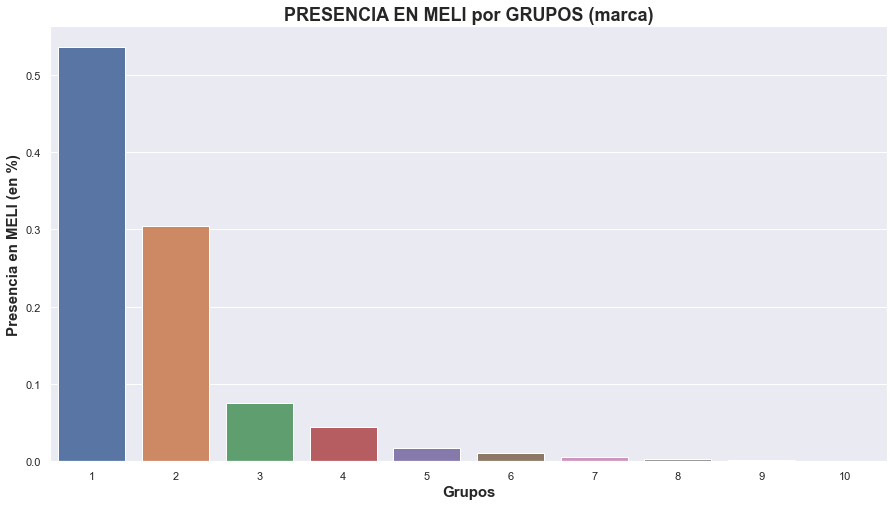

In [44]:
# PRESENCIA POR GRUPOS
plt.figure(figsize=(15,8))
d = df_output_ok.groupby('cuantil_cant')['cant'].sum()/sum(df_output_ok.cant)
ax = sns.barplot(x=d.index, y=d.values)

plt.xlabel('Grupos', fontweight ='bold', fontsize = 15)
plt.ylabel('Presencia en MELI (en %)', fontweight ='bold', fontsize = 15)
plt.title('PRESENCIA EN MELI por GRUPOS (marca)', fontweight ='bold', fontsize = 18)

In [45]:
# Marcas en cada grupo
df_output_ok.groupby('cuantil_cant').marca.unique()

cuantil_cant
1     [VOLKSWAGEN, FORD, PEUGEOT, CHEVROLET]
2           [RENAULT, FIAT, TOYOTA, CITROEN]
3                         [AUDI, HONDA, BMW]
4       [JEEP, NISSAN, CHERY, MERCEDES BENZ]
5                      [HYUNDAI, DODGE, KIA]
6              [SUZUKI, RAM, DS, MITSUBISHI]
7          [ALFA ROMEO, VOLVO, SUBARU, MINI]
8                    [CHRYSLER, SEAT, SMART]
9        [LAND ROVER, LIFAN, GEELY, PORSCHE]
10             [JAC, HAVAL, LEXUS, SHINERAY]
Name: marca, dtype: object

## 1_B) Nivel de agg: Marca-Modelo

In [46]:
# agrupacion
df_grouped = df_final.groupby(['marca_a','modelo_a']).agg({'modelo_a':'count'
                                                              ,'flag_outlier_price':'sum', 'flag_outlier_kms':'sum'
                                                              ,'price_meli_ok': ['std','mean']
                                                              ,'car_kms': ['std','mean']})
df_grouped.reset_index(inplace=True)
df_grouped.columns = df_grouped.columns.droplevel()
df_grouped.columns = ['marca','modelo','cant','outl_price','outl_kms','std_price','mean_price','std_kms','mean_kms']
df_grouped['cv_price'] =df_grouped.std_price / df_grouped.mean_price   # cv = coeficiente de variacion
df_grouped['cv_kms'] = df_grouped.std_kms / df_grouped.mean_kms
df_grouped.drop(['std_price','mean_price','std_kms','mean_kms'],1,inplace=True)
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()
for col in ['cant','outl_price','outl_kms']:
    
    df = df_grouped.copy()
    cols_to_drop = df.columns.values.tolist()
    cols_to_drop.remove('marca')
    cols_to_drop.remove('modelo')
    df.sort_values(by=col,ascending=False,inplace=True)
    
    df['perc_tot' + str('_'+col)] = df[col]/sum(df[col])
    df['cuantiles' + str('_'+col)] =pd.qcut(df[col], 10, duplicates='drop')

    placeholder= 'marca'
    tmp = df.groupby('cuantiles' + str('_'+col)).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
    leni = len(tmp)
    tmp['cuantil' + str('_'+col)] = list(reversed(list(np.arange(1,leni+1,1))))
    tmp['bin' + str('_'+col)] = tmp.index
    tmp.reset_index(drop=True,inplace=True)
    tmp.drop('placeholder',1,inplace=True)
    
    df = df.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+col)], right_on='bin' + str('_'+col))
    
    df.drop(cols_to_drop,1,inplace=True)
    
    df_output = df_output.merge(df, on=['marca','modelo'])

# seleccion y orden final de las columnas del output
df_output_ok_v2 = df_output[['marca','modelo'
                          ,'cant','perc_tot_cant','cuantil_cant','bin_cant'
                          ,'outl_price','perc_tot_outl_price','cv_price','cuantil_outl_price','bin_outl_price'
                          ,'outl_kms','perc_tot_outl_kms','cv_kms','cuantil_outl_kms','bin_outl_kms']]
df_output_ok_v2.sort_values(by='cant',ascending=False,inplace=True)

In [47]:
df_output_ok_v2.tail(20)

,marca,modelo,cant,perc_tot_cant,cuantil_cant,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms
341,ALFA ROMEO,159,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
340,PORSCHE,911,1,0.0000,10,"(0.999, 2.0]",1,0.0019,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
339,PORSCHE,Panamera,1,0.0000,10,"(0.999, 2.0]",1,0.0019,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
338,HYUNDAI,Terracan,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
337,HYUNDAI,Ioniq,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
336,MERCEDES BENZ,Clase CLS,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
324,ALFA ROMEO,Giulia,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
334,MERCEDES BENZ,Clase E,1,0.0000,10,"(0.999, 2.0]",1,0.0019,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
333,CITROEN,C4 Spacetourer,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"
332,CITROEN,C3 AirCross,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]"


In [48]:
# Mergeamos df_output a nivel marca y df_output a nivel marca-modelo para sumarle al segundo la col de deciles de presencia del primero
# el objetivo de esto es ver algunos casos de ejemplo donde a nivel agg marca eran decil bueno pero en agg marca-modelo decil malo
df_output_ok_v2 = df_output_ok_v2.merge(df_output_ok[['marca','cuantil_cant']], on='marca')

In [49]:
mask = df_output_ok_v2.modelo.apply(lambda x: x in ['Fiorino QUBO','Q8','Clase CLS','Traveller']) 
just_4_screen = df_output_ok_v2[mask][['marca','modelo','cuantil_cant_x','cuantil_cant_y']]
just_4_screen.columns = ['marca','modelo','grupo_MarcaModelo', 'grupo_Marca']
just_4_screen

,marca,modelo,grupo_MarcaModelo,grupo_Marca
60,PEUGEOT,Traveller,9,1
122,FIAT,Fiorino QUBO,10,2
182,AUDI,Q8,10,3
267,MERCEDES BENZ,Clase CLS,10,4


### Grupos (presencia x grupos)

In [50]:
asd = (df_output_ok_v2.groupby('cuantil_cant_x')['cant'].sum()/sum(df_output_ok_v2.cant))*100
asd

cuantil_cant_x
1    56.6391
2    21.3409
3    10.1163
4     5.2392
5     3.2019
6     1.6571
7     0.9942
8     0.4292
9     0.2771
10    0.1050
Name: cant, dtype: float64

In [51]:
# Escenario de cotizacion: Algoritmo
print(f'Algoritmo: {asd.iloc[0:4].sum()}')
print(f'Reglas: {asd.iloc[4:7].sum()}')
print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

Algoritmo: 93.3355065377232
Reglas: 5.853163823390924
Equipo Pricing: 0.8113296388858705


Text(0.5, 1.0, 'PRESENCIA EN MELI por GRUPOS (marca-modelo)')

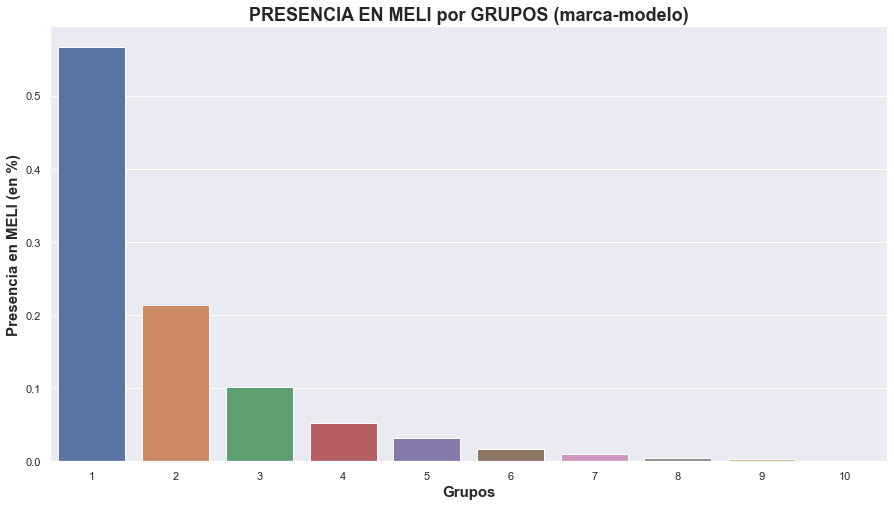

In [52]:
# PRESENCIA POR GRUPOS
plt.figure(figsize=(15,8))
d = df_output_ok_v2.groupby('cuantil_cant_x')['cant'].sum()/sum(df_output_ok_v2.cant)
ax = sns.barplot(x=d.index, y=d.values)

plt.xlabel('Grupos', fontweight ='bold', fontsize = 15)
plt.ylabel('Presencia en MELI (en %)', fontweight ='bold', fontsize = 15)
plt.title('PRESENCIA EN MELI por GRUPOS (marca-modelo)', fontweight ='bold', fontsize = 18)

In [53]:
# Marcas-modelos en cada grupo
df_output_ok_v2['marca_modelo'] = df_output_ok_v2['marca'] + str(' - ') +df_output_ok_v2['modelo']
df_output_ok_v2.head()

,marca,modelo,cant,perc_tot_cant,cuantil_cant_x,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms,cuantil_cant_y,marca_modelo
0,TOYOTA,Hilux,1747,0.0316,1,"(446.3, 1747.0]",13,0.0243,1.0402,1,"(3.0, 70.0]",165,0.1451,0.8926,1,"(7.0, 165.0]",2,TOYOTA - Hilux
1,TOYOTA,Corolla,1284,0.0233,1,"(446.3, 1747.0]",2,0.0037,1.1771,2,"(1.0, 3.0]",23,0.0202,0.7153,1,"(7.0, 165.0]",2,TOYOTA - Corolla
2,TOYOTA,Etios,540,0.0098,1,"(446.3, 1747.0]",0,0.0000,0.2184,3,"(-0.001, 1.0]",1,0.0009,0.8651,4,"(-0.001, 1.0]",2,TOYOTA - Etios
3,TOYOTA,Rav 4,161,0.0029,3,"(120.9, 231.0]",6,0.0112,0.6097,1,"(3.0, 70.0]",2,0.0018,0.5674,3,"(1.0, 3.0]",2,TOYOTA - Rav 4
4,TOYOTA,Yaris,100,0.0018,4,"(64.0, 120.9]",1,0.0019,0.2675,3,"(-0.001, 1.0]",0,0.0000,0.7447,4,"(-0.001, 1.0]",2,TOYOTA - Yaris


In [54]:
# Marcas-modelos en cada grupo
list(df_output_ok_v2[df_output_ok_v2['cuantil_cant_x']==10]['marca_modelo'].unique())

['VOLKSWAGEN - Transporter',
 'VOLKSWAGEN - Santana',
 'RENAULT - Laguna',
 'FIAT - Fiorino QUBO',
 'CITROEN - C4 Spacetourer',
 'CITROEN - C3 AirCross',
 'AUDI - Q8',
 'BMW - Serie 7',
 'SUZUKI - Baleno',
 'SUZUKI - Jimny',
 'NISSAN - Altima',
 'CHERY - Tiggo 4',
 'HYUNDAI - Veracruz',
 'HYUNDAI - Terracan',
 'HYUNDAI - Ioniq',
 'MERCEDES BENZ - Clase CLC',
 'MERCEDES BENZ - Clase CLS',
 'MERCEDES BENZ - Clase E',
 'KIA - Mohave',
 'KIA - Carens',
 'KIA - Opirus',
 'ALFA ROMEO - 159',
 'ALFA ROMEO - Giulia',
 'ALFA ROMEO - Stelvio',
 'ALFA ROMEO - GT',
 'CHRYSLER - 300',
 'CHRYSLER - Sebring',
 'SEAT - Cordoba',
 'SUBARU - WRX',
 'VOLVO - XC90',
 'VOLVO - XC70',
 'VOLVO - S80',
 'PORSCHE - Boxster',
 'PORSCHE - 911',
 'PORSCHE - Panamera',
 'JAC - T6',
 'JAC - S3',
 'HAVAL - H2',
 'HAVAL - H1',
 'LEXUS - NX',
 'LEXUS - IS',
 'SHINERAY - X30']

In [61]:
list(df_output_ok_v2[df_output_ok_v2['cuantil_cant_x']==3]['marca_modelo'].unique())

['TOYOTA - Rav 4',
 'VOLKSWAGEN - Passat',
 'VOLKSWAGEN - Scirocco',
 'PEUGEOT - 3008',
 'FORD - Mondeo',
 'FORD - Kuga',
 'RENAULT - Kwid',
 'RENAULT - Mégane',
 'RENAULT - Captur',
 'FIAT - Cronos',
 'FIAT - Mobi',
 'FIAT - Argo',
 'FIAT - Idea',
 'CHEVROLET - Meriva',
 'CHEVROLET - Corsa Classic',
 'CHEVROLET - Astra II',
 'CHEVROLET - Sonic',
 'CHEVROLET - Aveo',
 'CHEVROLET - Captiva',
 'CITROEN - Xsara Picasso',
 'CITROEN - Grand C4 Spacetourer',
 'AUDI - A5',
 'AUDI - Q5',
 'JEEP - Compass',
 'JEEP - Grand Cherokee',
 'HONDA - City',
 'DODGE - Journey',
 'SUZUKI - Fun',
 'RAM - 1500',
 'NISSAN - Kicks',
 'NISSAN - Tiida',
 'NISSAN - Frontier',
 'CHERY - Tiggo',
 'HYUNDAI - Tucson',
 'MERCEDES BENZ - Clase A']

In [60]:
list(df_output_ok_v2[df_output_ok_v2['cuantil_cant_x']==4]['marca_modelo'].unique())

['TOYOTA - Yaris',
 'VOLKSWAGEN - Tiguan',
 'VOLKSWAGEN - CrossFox',
 'VOLKSWAGEN - T-Cross',
 'VOLKSWAGEN - Virtus',
 'FORD - F-150',
 'RENAULT - Symbol',
 'RENAULT - Koleos',
 'FIAT - Qubo',
 'FIAT - Grand Siena',
 'FIAT - Weekend',
 'FIAT - Ducato',
 'CHEVROLET - Vectra',
 'CHEVROLET - Cobalt',
 'CHEVROLET - Montana',
 'CITROEN - C3 Picasso',
 'CITROEN - C4 Cactus',
 'CITROEN - C4 Aircross',
 'AUDI - TT',
 'AUDI - Q3',
 'JEEP - Wrangler',
 'BMW - X1',
 'BMW - Serie 2',
 'DODGE - Ram',
 'NISSAN - Versa',
 'NISSAN - Sentra',
 'NISSAN - March',
 'CHERY - QQ',
 'KIA - Sorento',
 'KIA - Sportage',
 'DS - DS3',
 'MITSUBISHI - L-200',
 'MINI - Cooper']

In [58]:
grupos_df = df_output_ok_v2[['cuantil_cant_x','marca','modelo']].copy()
grupos_df.to_csv('{}grupos_df.csv'.format(path_save))

**Casos raros**

In [55]:
# aircross de citroen
mask1 = df_output_ok_v2['marca']=='CITROEN'
mask2 = df_output_ok_v2.modelo.apply(lambda x: 'Air' in x)
df_output_ok_v2[(mask1 & mask2)]

,marca,modelo,cant,perc_tot_cant,cuantil_cant_x,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms,cuantil_cant_y,marca_modelo
158,CITROEN,C4 Aircross,98,0.0018,4,"(64.0, 120.9]",0,0.0000,0.3649,3,"(-0.001, 1.0]",0,0.0000,0.4527,4,"(-0.001, 1.0]",2,CITROEN - C4 Aircross
166,CITROEN,C5 Aircross,3,0.0001,9,"(2.0, 5.0]",0,0.0000,0.0664,3,"(-0.001, 1.0]",0,0.0000,0.9911,4,"(-0.001, 1.0]",2,CITROEN - C5 Aircross
168,CITROEN,C3 AirCross,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,3,"(-0.001, 1.0]",0,0.0000,nan,4,"(-0.001, 1.0]",2,CITROEN - C3 AirCross


### Correlacion: Presencia vs Precios ilogicos

In [164]:
df_final.columns

Index(['car_id', 'runtime', 'date', 'price_meli_ok', 'car_year', 'car_kms',
       'car_location_1', 'marca_a', 'modelo_a', 'version_a', 'seg_a',
       'subseg_a', 'flag_outlier_price', 'flag_outlier_kms'],
      dtype='object')

In [174]:
# agrupacion: marca-modelo
df_grouped_v2 = df_final.groupby(['marca_a', 'modelo_a']).agg({'modelo_a':'count'
                                                              ,'flag_outlier_price':'sum', 'flag_outlier_kms':'sum'
                                                              ,'price_meli_ok': ['std','mean']
                                                              ,'car_kms': ['std','mean']})
df_grouped_v2.reset_index(inplace=True)
df_grouped_v2.columns = df_grouped_v2.columns.droplevel()
df_grouped_v2.columns = ['marca','modelo','cant','outl_price','outl_kms','std_price','mean_price','std_kms','mean_kms']
df_grouped_v2['cv_price'] =df_grouped_v2.std_price / df_grouped_v2.mean_price   # cv = coeficiente de variacion
df_grouped_v2['cv_kms'] = df_grouped_v2.std_kms / df_grouped_v2.mean_kms
df_grouped_v2.drop(['std_price','mean_price','std_kms','mean_kms'],1,inplace=True)
df_grouped_v2.sort_values(by='cant',ascending=False,inplace=True)

<AxesSubplot:xlabel='cant', ylabel='outl_price'>

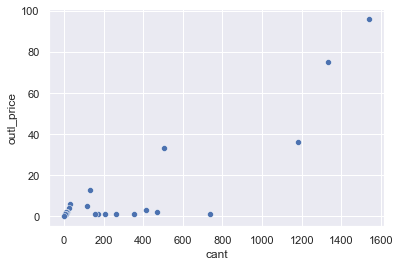

In [175]:
mask = df_grouped_v2.cv_price > 1.1
sns.scatterplot(data=df_grouped_v2[mask], x="cant", y="outl_price")

In [176]:
# matriz de correlación
df_grouped_v2[mask][['cant','outl_price']].corr()

,cant,outl_price
cant,1.0000,0.8697
outl_price,0.8697,1.0000


In [108]:
mask = df_output_ok.cv_price > 1.0
df_output_ok[mask].groupby('cuantil_cant')['outl_price'].sum()/sum(df_output_ok[mask].outl_price)

cuantil_cant
1   0.3872
2   0.2597
3   0.2255
5   0.1244
7   0.0031
Name: outl_price, dtype: float64

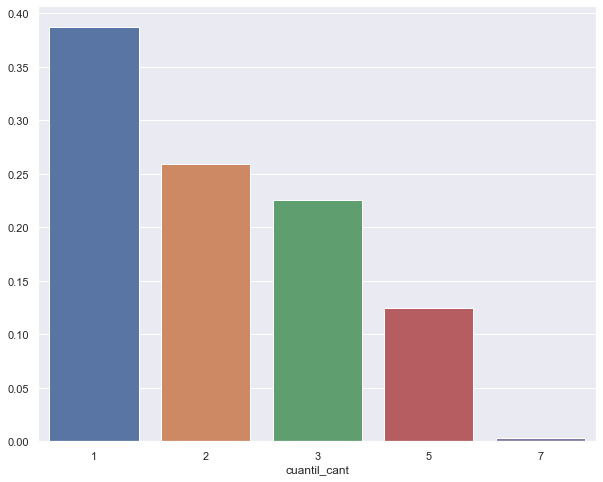

In [116]:
# Figure Size
fig = plt.figure(figsize =(10, 8))
 
# Horizontal Bar Plot
mask = df_output_ok.cv_price > 1.0
d = df_output_ok[mask].groupby('cuantil_cant')['outl_price'].sum()/sum(df_output_ok[mask].outl_price)
#plt.bar(d.index, d.values)
ax = sns.barplot(x=d.index, y=d.values)
 
# Show Plot
#plt.show()

Text(0.5, 1.0, 'Relación entre PRESENCIA y PRECIOS ILÓGICOS')

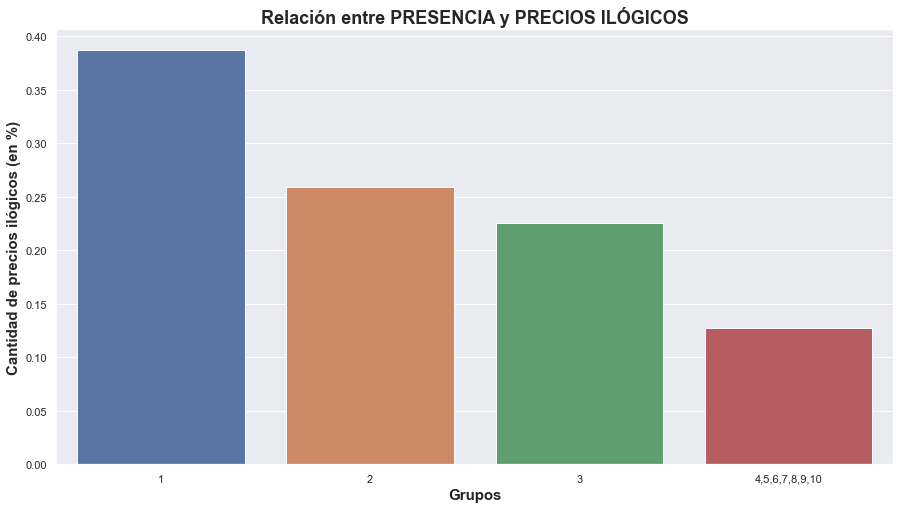

In [127]:
# toqueteamos el grafico anterior para que tenga un mejor impacto en la ppt
lst1 = ['1','2','3','4,5,6,7,8,9,10']
lst2 = [0.3872, 0.2597, 0.2255, 0.1276]

fig = plt.figure(figsize =(15, 8))
ax = sns.barplot(x=lst1, y=lst2)

plt.xlabel('Grupos', fontweight ='bold', fontsize = 15)
plt.ylabel('Cantidad de precios ilógicos (en %)', fontweight ='bold', fontsize = 15)
plt.title('Relación entre PRESENCIA y PRECIOS ILÓGICOS',  fontweight ='bold', fontsize = 18)

# 2) VERSIONES

Assumptions: <br>
* cuanto más versiones tenga un marca-modelo, mayor volatilidad tendrá en el precio --> Validarlo

In [177]:
df_final.columns

Index(['car_id', 'runtime', 'date', 'price_meli_ok', 'car_year', 'car_kms',
       'car_location_1', 'marca_a', 'modelo_a', 'version_a', 'seg_a',
       'subseg_a', 'flag_outlier_price', 'flag_outlier_kms'],
      dtype='object')

In [180]:
df_final.version_a.nunique()

2431

**Promedio de cantidad de versiones por grupo**

In [284]:
# agrupacion
df_grouped_v3 = df_final.groupby(['marca_a', 'modelo_a']).agg({'version_a': lambda x: x.nunique()})
df_grouped_v3.reset_index(inplace=True)
df_grouped_v3.columns = ['marca','modelo','cant_vers']
df_grouped_v3

,marca,modelo,cant_vers
0,ALFA ROMEO,147,2
1,ALFA ROMEO,159,2
2,ALFA ROMEO,GT,1
3,ALFA ROMEO,Giulia,1
4,ALFA ROMEO,Giulietta,6
...,...,...,...
343,VOLVO,V40,6
344,VOLVO,V70,1
345,VOLVO,XC40,1
346,VOLVO,XC60,8


In [296]:
df_output_ok_v2 = df_output_ok_v2.merge(df_grouped_v3, on=['marca','modelo'])

In [300]:
# chequeo
df_output_ok_v2[df_output_ok_v2['marca']=='TOYOTA'][['marca','modelo','cant','cant_vers']]

,marca,modelo,cant,cant_vers
0,TOYOTA,Hilux,1539,46
1,TOYOTA,Corolla,1012,30
2,TOYOTA,Etios,416,10
3,TOYOTA,Rav 4,131,12
4,TOYOTA,Yaris,77,6
5,TOYOTA,Land Cruiser,29,6
6,TOYOTA,86,25,1
7,TOYOTA,Hiace,18,4
8,TOYOTA,Camry,15,5
9,TOYOTA,Prius,14,1


In [292]:
# chequeo
mask1= df_final.marca_a == 'TOYOTA'
mask2 = df_final.modelo_a == 'Hilux'
len(df_final[(mask1 & mask2)]['version_a'].unique())

46

In [301]:
df_output_ok_v2.head()

,marca,modelo,cant,perc_tot_cant,cuantil_cant_x,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms,cuantil_cant_y,marca_modelo,cant_vers
0,TOYOTA,Hilux,1539,0.0323,1,"(383.8, 1539.0]",96,0.0907,1.1868,1,"(7.3, 96.0]",24,0.1548,0.9607,1,"(1.0, 24.0]",2,TOYOTA - Hilux,46
1,TOYOTA,Corolla,1012,0.0213,1,"(383.8, 1539.0]",3,0.0028,0.5692,2,"(2.0, 7.3]",3,0.0194,0.7048,1,"(1.0, 24.0]",2,TOYOTA - Corolla,30
2,TOYOTA,Etios,416,0.0087,1,"(383.8, 1539.0]",3,0.0028,2.5229,2,"(2.0, 7.3]",2,0.0129,5.1621,1,"(1.0, 24.0]",2,TOYOTA - Etios,10
3,TOYOTA,Rav 4,131,0.0028,3,"(102.8, 202.4]",13,0.0123,1.2414,1,"(7.3, 96.0]",0,0.0000,0.5480,2,"(-0.001, 1.0]",2,TOYOTA - Rav 4,12
4,TOYOTA,Yaris,77,0.0016,4,"(57.0, 102.8]",2,0.0019,0.3982,3,"(1.0, 2.0]",0,0.0000,0.9805,2,"(-0.001, 1.0]",2,TOYOTA - Yaris,6


In [304]:
# Rdo final: Promedio de cant de versiones por grupo
df = df_output_ok_v2.copy()
df.rename(columns={'cuantil_cant_x':'Grupos'},inplace=True)
df_rdo = df.groupby('Grupos').agg({'cant_vers':'mean'})
df_rdo

,cant_vers
Grupos,
1,26.3143
2,14.0857
3,10.0571
4,7.7576
5,6.1111
6,5.0000
7,3.6500
8,2.8519
9,1.5135


Vemos la clara correlación que indica que cuanto más presencia tiene el marca-modelo, más cantidad de versiones tiene

**Volatilidad de los precios de las versiones para un marca-modelo**

In [305]:
# agrupacion: marca-modelo-version
df_grouped_v4 = df_final.groupby(['marca_a', 'modelo_a','version_a']).agg({'price_meli_ok': 'median'})
df_grouped_v4.reset_index(inplace=True)
df_grouped_v4

,marca_a,modelo_a,version_a,price_meli_ok
0,ALFA ROMEO,147,1.9 JTD (150cv) 5Ptas.,1424625.0000
1,ALFA ROMEO,147,2.0 TS MT (150cv) 5Ptas.,2063250.0000
2,ALFA ROMEO,159,2.2 JTS 6MT Progression (185cv),1965000.0000
3,ALFA ROMEO,159,2.2 JTS Selespeed Cuero (185cv),2947500.0000
4,ALFA ROMEO,GT,1.9 JTD Distinctive (150cv),5747625.0000
...,...,...,...,...
2709,VOLVO,XC60,T5 High Plus (240cv),7500000.0000
2710,VOLVO,XC60,T6 AWD High Luxury / Premium (304hp),3535035.0000
2711,VOLVO,XC60,T6 AWD High Luxury R-Design (304hp),5894803.5000
2712,VOLVO,XC60,T6 AWD High Plus (304hp),3144000.0000


In [194]:
# chequeo
df_grouped_v4[df_grouped_v4['marca_a']=='VOLKSWAGEN']

,marca_a,modelo_a,version_a,price_meli_ok
2323,VOLKSWAGEN,Amarok,2.0 TDI (122cv) 4x2 C/Doble Startline,2784615.3846
2324,VOLKSWAGEN,Amarok,2.0 TDI (122cv) 4x4 C/Doble Startline,2911428.5714
2325,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Doble Trendline (L17),3061187.5000
2326,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Simple Startline,3338679.9242
2327,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Simple Trendline (L17),4406750.0000
...,...,...,...,...
2670,VOLKSWAGEN,Voyage,1.6 Conceptline (101cv) (L08),1610809.0758
2671,VOLKSWAGEN,Voyage,1.6 Highline (101cv) (MY14 ABG ABS),1434114.7059
2672,VOLKSWAGEN,Voyage,1.6 Highline I-Motion (101cv),1032666.3333
2673,VOLKSWAGEN,Voyage,1.6 MSI Trendline (101cv) (L20) DISCONTINUO,1077833.3333


In [306]:
# cv_vers
df_rdo2 = df_grouped_v4.groupby(['marca_a','modelo_a']).agg({'price_meli_ok':['std','mean']})

df_rdo2.reset_index(inplace=True)
df_rdo2.columns = df_rdo2.columns.droplevel()
df_rdo2.columns = ['marca','modelo','std_vers','mean_vers']
df_rdo2['cv_vers'] =df_rdo2.std_vers / df_rdo2.mean_vers

df_rdo2

,marca,modelo,std_vers,mean_vers,cv_vers
0,ALFA ROMEO,147,451576.0681,1743937.5000,0.2589
1,ALFA ROMEO,159,694732.4125,2456250.0000,0.2828
2,ALFA ROMEO,GT,nan,5747625.0000,nan
3,ALFA ROMEO,Giulia,nan,7467000.0000,nan
4,ALFA ROMEO,Giulietta,1557002.1350,3490037.5000,0.4461
...,...,...,...,...,...
343,VOLVO,V40,1147327.7431,4226750.0000,0.2714
344,VOLVO,V70,nan,1250000.0000,nan
345,VOLVO,XC40,nan,19453500.0000,nan
346,VOLVO,XC60,2944029.3214,5403798.5625,0.5448


In [308]:
mask = df_rdo2.marca == 'TOYOTA'
df_rdo2[mask]

,marca,modelo,std_vers,mean_vers,cv_vers
297,TOYOTA,86,nan,4519500.0000,nan
298,TOYOTA,Avensis,nan,1690000.0000,nan
299,TOYOTA,C-HR Hybrid,nan,8253000.0000,nan
300,TOYOTA,Camry,699608.4044,2248670.0000,0.3111
301,TOYOTA,Corolla,1534186.7342,2608232.5000,0.5882
302,TOYOTA,Corolla Cross,640283.2161,6216475.0000,0.1030
303,TOYOTA,Etios,457773.9010,2022500.0000,0.2263
304,TOYOTA,Hiace,1906804.2801,7516375.0000,0.2537
305,TOYOTA,Hilux,14043731.9827,6329218.4783,2.2189
306,TOYOTA,Innova,nan,4500000.0000,nan


In [310]:
# cv_vers_ok
df_rdo2['cv_vers_ok'] =np.where(df_rdo2['cv_vers'].isnull(), 0, df_rdo2['cv_vers'])
df_rdo2[mask]

,marca,modelo,std_vers,mean_vers,cv_vers,cv_vers_ok
297,TOYOTA,86,nan,4519500.0000,nan,0.0000
298,TOYOTA,Avensis,nan,1690000.0000,nan,0.0000
299,TOYOTA,C-HR Hybrid,nan,8253000.0000,nan,0.0000
300,TOYOTA,Camry,699608.4044,2248670.0000,0.3111,0.3111
301,TOYOTA,Corolla,1534186.7342,2608232.5000,0.5882,0.5882
302,TOYOTA,Corolla Cross,640283.2161,6216475.0000,0.1030,0.1030
303,TOYOTA,Etios,457773.9010,2022500.0000,0.2263,0.2263
304,TOYOTA,Hiace,1906804.2801,7516375.0000,0.2537,0.2537
305,TOYOTA,Hilux,14043731.9827,6329218.4783,2.2189,2.2189
306,TOYOTA,Innova,nan,4500000.0000,nan,0.0000


In [311]:
# join con la tabla master
df_output_ok_v2 = df_output_ok_v2.merge(df_rdo2[['marca','modelo','cv_vers_ok']], on=['marca','modelo'])
df_output_ok_v2

,marca,modelo,cant,perc_tot_cant,cuantil_cant_x,bin_cant,outl_price,perc_tot_outl_price,cv_price,cuantil_outl_price,bin_outl_price,outl_kms,perc_tot_outl_kms,cv_kms,cuantil_outl_kms,bin_outl_kms,cuantil_cant_y,marca_modelo,cant_vers,cv_vers_ok
0,TOYOTA,Hilux,1539,0.0323,1,"(383.8, 1539.0]",96,0.0907,1.1868,1,"(7.3, 96.0]",24,0.1548,0.9607,1,"(1.0, 24.0]",2,TOYOTA - Hilux,46,2.2189
1,TOYOTA,Corolla,1012,0.0213,1,"(383.8, 1539.0]",3,0.0028,0.5692,2,"(2.0, 7.3]",3,0.0194,0.7048,1,"(1.0, 24.0]",2,TOYOTA - Corolla,30,0.5882
2,TOYOTA,Etios,416,0.0087,1,"(383.8, 1539.0]",3,0.0028,2.5229,2,"(2.0, 7.3]",2,0.0129,5.1621,1,"(1.0, 24.0]",2,TOYOTA - Etios,10,0.2263
3,TOYOTA,Rav 4,131,0.0028,3,"(102.8, 202.4]",13,0.0123,1.2414,1,"(7.3, 96.0]",0,0.0000,0.5480,2,"(-0.001, 1.0]",2,TOYOTA - Rav 4,12,0.7496
4,TOYOTA,Yaris,77,0.0016,4,"(57.0, 102.8]",2,0.0019,0.3982,3,"(1.0, 2.0]",0,0.0000,0.9805,2,"(-0.001, 1.0]",2,TOYOTA - Yaris,6,0.6862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,HAVAL,H6,2,0.0000,10,"(0.999, 2.0]",0,0.0000,0.0275,4,"(-0.001, 1.0]",0,0.0000,0.6203,2,"(-0.001, 1.0]",10,HAVAL - H6,1,0.0000
344,HAVAL,H2,1,0.0000,10,"(0.999, 2.0]",0,0.0000,nan,4,"(-0.001, 1.0]",0,0.0000,nan,2,"(-0.001, 1.0]",10,HAVAL - H2,1,0.0000
345,LEXUS,NX,2,0.0000,10,"(0.999, 2.0]",2,0.0019,0.0000,3,"(1.0, 2.0]",0,0.0000,0.0000,2,"(-0.001, 1.0]",10,LEXUS - NX,1,0.0000
346,LEXUS,UX,1,0.0000,10,"(0.999, 2.0]",1,0.0009,nan,4,"(-0.001, 1.0]",0,0.0000,nan,2,"(-0.001, 1.0]",10,LEXUS - UX,1,0.0000


In [314]:
# Top de modelos con alta volatilidad de version (nos basamos en el coeficiente de variacion)
df_rdo3 = df_output_ok_v2.sort_values(by='cv_vers_ok', ascending=False)[['marca','modelo','cv_vers_ok']]

In [316]:
df_rdo3.head(20)

,marca,modelo,cv_vers_ok
122,AUDI,A3,2.7391
65,PEUGEOT,2008,2.4988
0,TOYOTA,Hilux,2.2189
295,MITSUBISHI,Outlander,1.7589
56,FORD,Courier,1.5013
162,CHEVROLET,Corvette,1.1007
305,SUBARU,Impreza,1.0721
25,VOLKSWAGEN,Polo,0.8880
199,HONDA,Accord,0.8646
320,LAND ROVER,Range Rover,0.8506


In [317]:
df_rdo4 = df_output_ok_v2[['marca','modelo','cuantil_cant_x','cv_vers_ok']].groupby('cuantil_cant_x').agg({'cv_vers_ok':'mean'})
df_rdo4

,cv_vers_ok
cuantil_cant_x,
1,0.4975
2,0.4262
3,0.3013
4,0.3696
5,0.3077
6,0.3273
7,0.2990
8,0.2052
9,0.1109
